# Generative Deep Learning DeepDream



> BSc Computer Science 33680787 Seonjoo Hwang





I. Introduction

II. Methodology

III. Results

IV. Conclusions

# I. Introduction


I will be demonstrating what we learned from 'Artificial Intelligence' module Week 9 and 'Deep Learning with Python' Chapter 12.2. (Chollet, F. (2017). Deep learning with python. Manning Publications.). The codes and explanations are from these materials.

## DeepDream

DeepDream is an artistic image-modification technique that uses the representations learned by convolutional neural networks. It was first released by Google in the sum- mer of 2015 as an implementation written using the Caffe deep learning library. (Chollet, F. (2017). Deep learning with python. Manning Publications.)

## Workflow

1. Select the layers

2. Build a modified version of network that return the activations from selected layers

3. Process the image through the new network;

4. Calculate the gradients of the image with respect to the activations

5. Adjust the image by applying the gradients to enhance the features


# II. Implementation

In [1]:
# import necessary libraries and modules
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

import tensorflow as tf
from tensorflow import keras

**Fetching the test image**

I will use one of my favourite artist Munch's 'The Scream'.

It has vivid and dynamic colour palette which can show dramatic effect of DeepDream.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


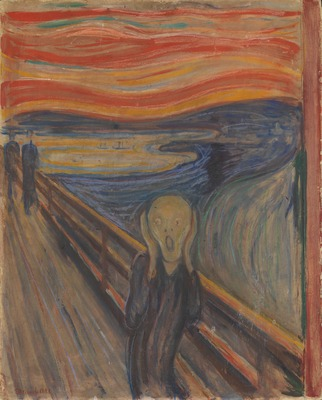

In [3]:
# Replace with the actual path to image on Google Drive
image_path = '/content/drive/MyDrive/AI/small_scream.jpg'

# Load the image
image = Image.open(image_path)

# Display the image
display(image)

**Instantiating a pretrained model, `InceptionV3'**

I will be using inception_v3 model which is the original model of 'DeepDream' from 'Deep Learning with Python'.

In [4]:
model = tf.keras.applications.inception_v3.InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


**model inspection**

Check model architecture and find out name of layers to modify.

In [5]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalizati

**1. Select the layers**

Configuring the contribution of each layer

In [12]:
layer_settings = {
    "mixed3": 1.0,
    "mixed5": 1.0,
}

**2. Building the modified model**

In [13]:
# Define a new model
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [
            model.get_layer(name)
            for name in layer_settings.keys()
        ]
    ]
)
# functional syntax: our new model
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

**3. Process the image through the new network**

**The DeepDream loss**

The loss function is designed to increase the activation of certain neurons in the chosen layers. By maximizing these activations, the network essentially "hallucinates" features, causing the input image to be modified in a way that emphasizes and exaggerates patterns recognized by those neurons.

In [14]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation))
    return loss

**4. Calculate the gradients of the image**

Gradient ascent is used to increase the activation of specific neurons or layers in the neural network. By doing so, the process emphasizes the features that these neurons recognize, such as edges, textures, or more complex patterns. The process is iterative, meaning the image is modified step by step. After each modification, the new image is fed back into the network, and the process repeats. With each iteration, the selected features become more pronounced, leading to surreal appearance typical of DeepDream images.


In [15]:
@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)                # compute the loss
    grads = tape.gradient(loss, image)            # compute the gradients
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads                # modify the image
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)           #     modify the image using the gradient
        if max_loss is not None and loss > max_loss:                       #     cut-off for loss
            break
        print(f"... Loss value at step {i+1}: {loss:.2f}\r", end="")
    print()
    return image

**Image processing utilities**

Images are resized to match the input dimensions expected by the network, ensuring compatibility and efficient processing.

In [16]:
def preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path)
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)                              # add batch dimension
    img = tf.keras.applications.inception_v3.preprocess_input(img) # rescale
    return img

def deprocess_image(img):
    img = tf.reshape(img, (img.shape[1], img.shape[2], 3))         # remove batch dim
    img /= 2.0                                                     # denormalisation
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**5. Update the image**


Running gradient ascent over multiple successive octaves

In [17]:
# Parameters to modify each iteration
step = 10                   # learning rate
num_octave = 3
octave_scale = 1.2
iterations = 30
max_loss = 20.              # a cut-off point for loss
reinject_details = True
display_intermediate = False

original_img = preprocess_image(image_path)
original_shape = original_img.shape[1:3]

start_power = 1

successive_shapes = [original_shape]   # 'octaves'
for i in range(start_power, num_octave+start_power):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]


print("Successive shapes:")
print(*[f"    - {sh}" for sh in successive_shapes], sep="\n")
print("-" * 40)

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])     # START: resize to smallest

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i+1} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )

    # lost : the difference between the downscaled and the upscaled shrunk original
    if reinject_details:
        upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
        same_size_original = tf.image.resize(original_img, shape)
        lost_detail = same_size_original - upscaled_shrunk_original_img
        img += lost_detail
        shrunk_original_img = tf.image.resize(original_img, shape)

    if display_intermediate and i+1 < num_octave:
        display(Image.fromarray(deprocess_image(img)))

    print()

Successive shapes:
    - (231, 186)
    - (277, 223)
    - (333, 268)
    - (400, 322)
----------------------------------------
Processing octave 1 with shape (231, 186)
... Loss value at step 30: 10.25

Processing octave 2 with shape (277, 223)
... Loss value at step 30: 12.61

Processing octave 3 with shape (333, 268)
... Loss value at step 30: 12.97

Processing octave 4 with shape (400, 322)
... Loss value at step 30: 13.42



# III. Results

Experiment with different layers and parameters

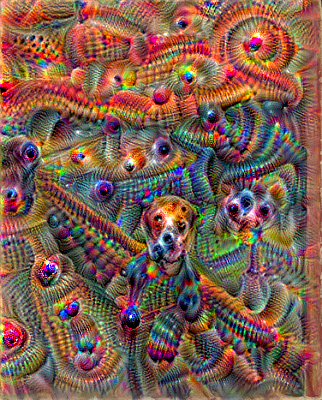

In [18]:
display(Image.fromarray(deprocess_image(img)))
tf.keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

layer_settings = {"mixed3": 1.0, "mixed4": 1.0, "mixed5": 1.0, "mixed6": 1.0, "mixed7": 1.0}

step = 10                   
num_octave = 3               
octave_scale = 1.1           
iterations = 30              
max_loss = 15.              

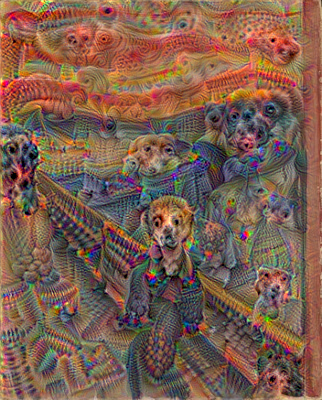

layer_settings = {"mixed3": 1.0, "mixed5": 1.0}

step = 10                   
num_octave = 7               
octave_scale = 1           
iterations = 30              
max_loss = 15.              

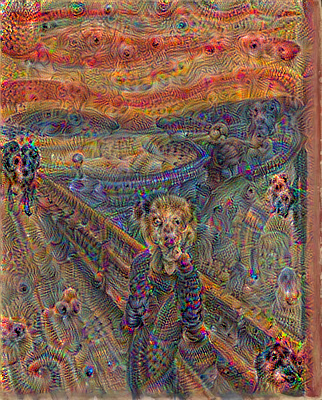

layer_settings = {"mixed3": 1.0, "mixed5": 1.0}

step = 10                   
num_octave = 3               
octave_scale = 1           
iterations = 30              
max_loss = 25.              

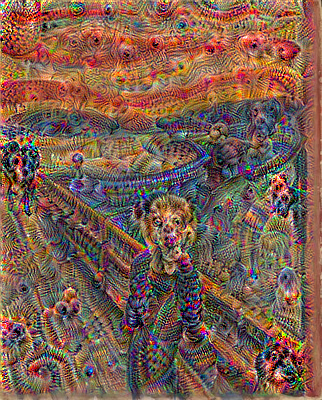

# IV. Conclusion

In this notebook, the DeepDream technique was explored as a unique application of convolutional neural networks (CNNs) in the context of generative deep learning. By following the methodology outlined from both the "Artificial Intelligence" module and the reference material "Deep Learning with Python" by Francois Chollet, the practical aspects of DeepDream were demonstrated. The results showcased the potential of CNNs to create visually intriguing, dream-like images by amplifying patterns recognized by the network. This exploration highlights the creative intersection of art and artificial intelligence, emphasizing how deep learning techniques can be harnessed to push the boundaries of digital art.


**Potential Improvements**

**Layer Selection Optimization**: Experimenting with different layers or combinations of layers could yield more diverse and potentially more intricate visual effects.

**Advanced Post-Processing**: Implementing more sophisticated image processing techniques
